In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from google.colab import files
uploaded = files.upload()


Saving Transactions.csv to Transactions.csv
Saving Products.csv to Products.csv
Saving Customers.csv to Customers.csv


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA

# Load the datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Check the first few rows of both datasets
print(customers.head())
print(transactions.head())


  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue   Price  
0      300.68  300.68  
1      300.68  300.68  
2      300.68  300.68  
3      601.36  300.68  
4      902.04  300.68  


In [13]:
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'], errors='coerce')
customers['SignupDays'] = (pd.to_datetime('today') - customers['SignupDate']).dt.days


In [15]:
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'], format='%Y-%m-%d %H:%M:%S')


In [16]:
# Convert TransactionDate to datetime
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'], format='%d-%m-%Y %H:%M')

# Aggregate data by CustomerID
agg_data = transactions.groupby('CustomerID').agg(
    total_spend=('TotalValue', 'sum'),
    avg_transaction_value=('TotalValue', 'mean'),
    freq_of_purchases=('TransactionID', 'count'),
    avg_quantity_purchased=('Quantity', 'mean')
).reset_index()

print(agg_data.head())


  CustomerID  total_spend  avg_transaction_value  freq_of_purchases  \
0      C0001      3354.52                670.904                  5   
1      C0002      1862.74                465.685                  4   
2      C0003      2725.38                681.345                  4   
3      C0004      5354.88                669.360                  8   
4      C0005      2034.24                678.080                  3   

   avg_quantity_purchased  
0                2.400000  
1                2.500000  
2                3.500000  
3                2.875000  
4                2.333333  


In [17]:
# Merge the two datasets on CustomerID
customer_features = pd.merge(agg_data, customers[['CustomerID', 'Region', 'SignupDays']], on='CustomerID', how='left')

# Check the merged data
print(customer_features.head())


  CustomerID  total_spend  avg_transaction_value  freq_of_purchases  \
0      C0001      3354.52                670.904                  5   
1      C0002      1862.74                465.685                  4   
2      C0003      2725.38                681.345                  4   
3      C0004      5354.88                669.360                  8   
4      C0005      2034.24                678.080                  3   

   avg_quantity_purchased         Region  SignupDays  
0                2.400000  South America         932  
1                2.500000           Asia        1079  
2                3.500000  South America         326  
3                2.875000  South America         841  
4                2.333333           Asia         896  


In [18]:
# One-hot encode the 'Region' column
customer_features = pd.get_dummies(customer_features, columns=['Region'], drop_first=True)

print(customer_features.head())


  CustomerID  total_spend  avg_transaction_value  freq_of_purchases  \
0      C0001      3354.52                670.904                  5   
1      C0002      1862.74                465.685                  4   
2      C0003      2725.38                681.345                  4   
3      C0004      5354.88                669.360                  8   
4      C0005      2034.24                678.080                  3   

   avg_quantity_purchased  SignupDays  Region_Europe  Region_North America  \
0                2.400000         932          False                 False   
1                2.500000        1079          False                 False   
2                3.500000         326          False                 False   
3                2.875000         841          False                 False   
4                2.333333         896          False                 False   

   Region_South America  
0                  True  
1                 False  
2                  True  


In [19]:
# Select features for clustering (excluding CustomerID and SignupDays, as they are not relevant for clustering)
features = customer_features.drop(columns=['CustomerID', 'SignupDays'])

# Standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Check the scaled features
print(scaled_features[:5])


[[-0.06170143 -0.07026341 -0.01145819 -0.23346379 -0.57928445 -0.54831888
   1.54041597]
 [-0.87774353 -0.93493297 -0.46749414 -0.05496886 -0.57928445 -0.54831888
  -0.6491753 ]
 [-0.40585722 -0.02627131 -0.46749414  1.72998043 -0.57928445 -0.54831888
   1.54041597]
 [ 1.03254704 -0.0767689   1.35664965  0.61438712 -0.57928445 -0.54831888
   1.54041597]
 [-0.78392861 -0.04002806 -0.92353008 -0.35246041 -0.57928445 -0.54831888
  -0.6491753 ]]


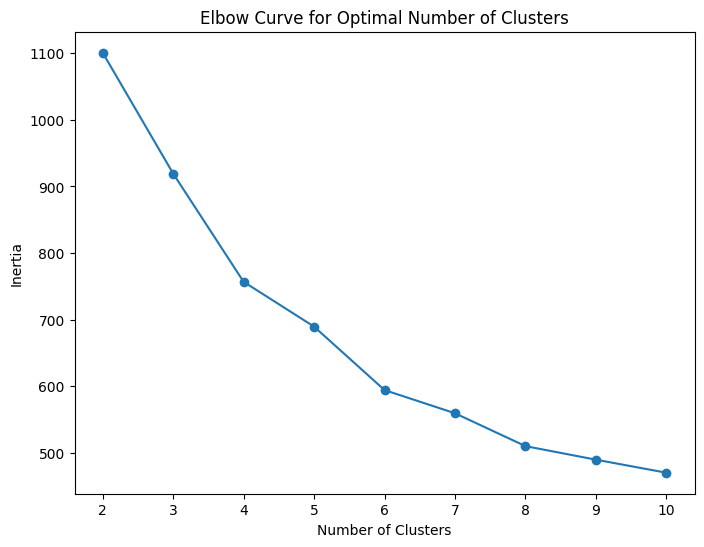

In [20]:
# Try clustering with a range of cluster numbers
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve to select the optimal number of clusters
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Curve for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Select the optimal number of clusters (based on the elbow method)
optimal_k = 4  # Update based on elbow curve


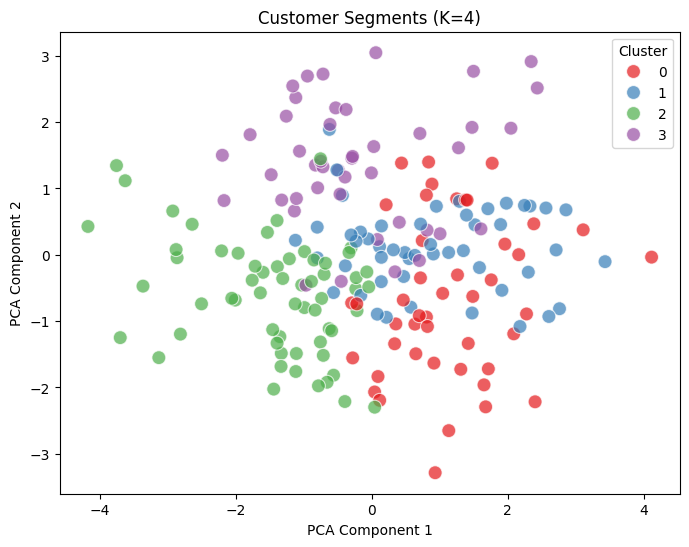

In [21]:
# Fit the KMeans model with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(scaled_features)

# Visualize the clusters using PCA (for 2D plotting)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)

# Plot the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=customer_features['Cluster'], palette='Set1', s=100, alpha=0.7)
plt.title(f'Customer Segments (K={optimal_k})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [22]:
# Calculate the Davies-Bouldin Index
dbi = davies_bouldin_score(scaled_features, customer_features['Cluster'])
print(f'Davies-Bouldin Index: {dbi}')


Davies-Bouldin Index: 1.372116925873926


In [24]:
# Exclude non-numeric columns before calculating the mean
numeric_columns = customer_features.select_dtypes(include=['float64', 'int64']).columns
cluster_summary = customer_features.groupby('Cluster')[numeric_columns].mean()

# Print the summary of the clusters
print(cluster_summary)

# Save the final data with clusters to a new CSV file
customer_features.to_csv('Customer_Segments.csv', index=False)


         total_spend  avg_transaction_value  freq_of_purchases  \
Cluster                                                          
0        4943.916000             851.283005           6.133333   
1        4230.377800             754.189900           5.660000   
2        1736.933833             531.703349           3.316667   
3        3449.645909             657.023298           5.500000   

         avg_quantity_purchased  SignupDays  
Cluster                                      
0                      2.778183  525.200000  
1                      2.638944  622.840000  
2                      2.269722  600.533333  
3                      2.510899  460.477273  
